In [99]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pyedflib
import time

import utils

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%config InlineBackend.figure_format = 'retina'

In [2]:
#signal = file.readSignal(channel)
#fs = file.getSampleFrequency(channel)
#file._close()
#del file


# 256 Hz
# Filter low cutoff 0.3 Hz
# Filter high cutoff 100Hz
# Sleep stage: RK page size 20s
# entre 18 y 33 años
# For this subset, sleep spindles are scored by two experts (V4 and V5) on N2 epochs
# and on channel C3 with linked-ear reference.
# Channel C3 with linked-ear reference -> Channel 13 (0-based): EEG C3-CLE
# Keep in mind: We were developing based on a bipolar derivation, using F4-C4
# Spindles are marked in C3, so we could use a bipolar derivation F3-C3 with those marks to keep the same kind of signal.
# To obtain this derivation we should do (F3-CLE)-(C3-CLE) = channel 22 - channel 13.


# " As of now, the MASS contains one cohort (C1) of 200 complete-night recordings sampled at 256 Hz and split 
# into five subsets. The second subset (C1/SS2) contains 19 nights from young healthy subjects. For this subset,
# sleep spindles are scored by two experts (V4 and V5) on N2 epochs and on channel C3 with linked-ear reference.
# A complete description can be found in (O'Reilly et al. (2014) [1]). It should be noted that relatively low inter
# rater agreement is expected between these two scorers since V4 used traditional 
# AASM scoring rules whereas V5 used an approach similar to (Ray et al., 2010). 
# In this case, both broad-band EEG signals (0.35-35 Hz band) and sigma filtered 
# signals (11-17 Hz band) were used in scoring to facilitate the identification 
# of short duration, small amplitude or obscured (e.g., by delta waves or K-complexes)
# spindles. Also, no minimal spindle duration was used by V5 and four nights 
# (out of the 19) were not scored due to recordings that were judged to reflect poor quality sleep
# (e.g., alpha intrusions during N2) or intermittent signal quality/artifact (Fogel, personal communication). "
#  O’Reilly, C., and Nielsen, T. (2015). Automatic sleep spindle detection: benchmarking with fine temporal
# resolution using open science tools. https://www.frontiersin.org/articles/10.3389/fnhum.2015.00353/full

# DL arch for sleep events:
# Data The experiments were performed on MASS SS2 [24]:
# 19 records from 19 subjects (11 females, 8 males,  23.6
#  3.7 years old), sampled at 256 Hz. The spindles have
# been scored by expert E1 (resp. E2) over 19 records (resp.
# 15) using different guidelines [14] resulting in  550 (resp.
#  1100) scored spindles per record. For records scored
# by both E1 and E2 500 spindles per record exhibit IoU
# > 0 (Gaussian-like distribution, pic at 0.6). The 15 records
# annotated by E1 and E2 were used for spindles detection
# benchmark. For K-complex detection, and joint spindle and
# K-complex detection, the 19 records scored by E1 were used.

# Proposed approach The proposed approach was benchmarked
# on signal from channel C3.

# A 5 split cross validation was used. A
# split stands for 10 training, 2 validation and 3 testing records for spindle detection.

# Spindles Detectors were compared to 4 gold standards:
# events scored by E1, E2, the union and the intersection of
# events scored by both E1 and E2, see Figure 2.

In [20]:
path_edf_file = "ssdata_mass/register/01-02-0001 PSG.edf"
file = pyedflib.EdfReader(path_edf_file)
for channel in range(27):
    label = file.getLabel(channel)
    print("Channel "+str(channel)+": "+label)
file._close()

Channel 0: Resp nasal
Channel 1: EEG T4-CLE
Channel 2: EEG P3-CLE
Channel 3: EOG Left Horiz
Channel 4: EEG F4-CLE
Channel 5: EOG Right Horiz
Channel 6: ECG I
Channel 7: EEG T6-CLE
Channel 8: EEG Cz-CLE
Channel 9: EEG T5-CLE
Channel 10: EEG F7-CLE
Channel 11: EOG Upper Vertic
Channel 12: EEG T3-CLE
Channel 13: EEG C3-CLE
Channel 14: EEG Fp2-CLE
Channel 15: EEG O1-CLE
Channel 16: EEG Pz-CLE
Channel 17: EEG O2-CLE
Channel 18: EEG Fp1-CLE
Channel 19: EEG P4-CLE
Channel 20: EMG Chin
Channel 21: EEG Fpz-CLE
Channel 22: EEG F3-CLE
Channel 23: EEG C4-CLE
Channel 24: EEG A2-CLE
Channel 25: EEG F8-CLE
Channel 26: EOG Lower Vertic


In [23]:
path_edf_file = "ssdata_mass/register/01-02-0001 PSG.edf"
file = pyedflib.EdfReader(path_edf_file)

channel_F3 = 22
channel_C3 = 13

signal_C3 = file.readSignal(channel_C3)
signal_F3 = file.readSignal(channel_F3)
signal_F3C3 = signal_F3 - signal_C3

fs = file.getSampleFrequency(channel_C3)
print("Sampling freq", fs)
file._close()

Sampling freq 256


7413248 samples
Time axis:  0.0 28957.99609375


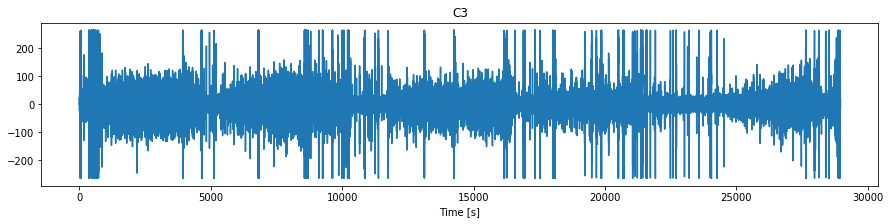

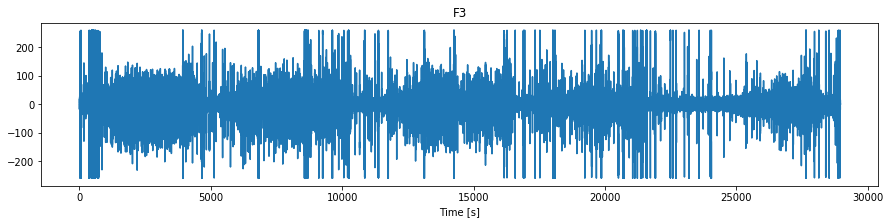

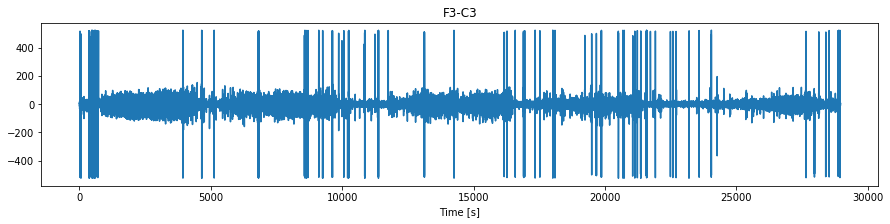

In [73]:
n_samples = len(signal_C3)
print(n_samples, "samples")
time_axis = np.arange(n_samples) / fs
print("Time axis: ", time_axis[0], time_axis[-1])

plt.figure(figsize=(15, 3))
plt.plot(time_axis, signal_C3)
plt.title('C3')
plt.xlabel('Time [s]')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(time_axis, signal_F3)
plt.title('F3')
plt.xlabel('Time [s]')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(time_axis, signal_F3C3)
plt.title('F3-C3')
plt.xlabel('Time [s]')
plt.show()

In [74]:
# Read stages
# Format of stages is onset | duration | description
path_edf_file = "ssdata_mass/label/states/01-02-0001 Base.edf"
file = pyedflib.EdfReader(path_edf_file)
print(file.annotations_in_file) # 1419
annotations = file.readAnnotations() # This is a 3-tuple
# first element is location in time
# second element is duration (always 20s)
# third element is stage
n = 1418
print("annotation: onset is %f    duration is %s    description is %s" % (annotations[0][n],annotations[1][n],annotations[2][n]))
file._close()

# First state has onset 
# Last state has onset 28920.761992, so it ends at 28940.761992
# But time axis has interval  (0.0 ; 28957.99609375) so we have to be careful. 
# We have to take into account the onset. The onset then is the time of beginning for page, asuming that
# t=0 is for the begining of the signal. We could crop the signal between the first onset and the last offset.

1419
annotation: onset is 28920.761992    duration is 19.9948120117    description is Sleep stage W


Sleep stage 4
S
l
e
e
p
 
s
t
a
g
e
 
4
single char: 4
1419
{'2', '3', '4', '?', 'R', 'W', '1'}
745


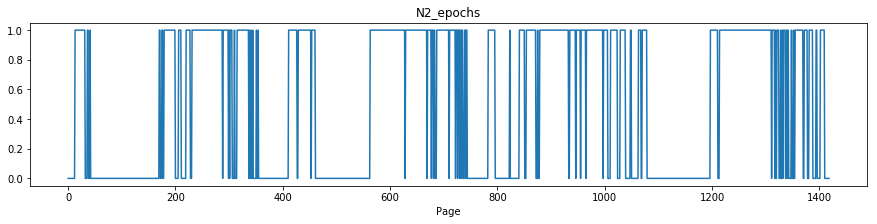

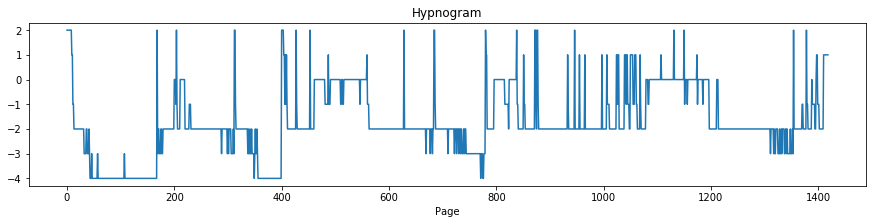

In [78]:
stages_str = annotations[2] # each element is <class 'numpy.str_'>
single_annot = stages_str[100]  #<class 'numpy.str_'>
print(single_annot)
for element in single_annot:
    print(element)
get_char = single_annot[-1]
print("single char:",get_char)

stages_str = annotations[2]
stages_char = [single_annot[-1] for single_annot in stages_str]
print(len(stages_char))
myset = set(stages_char)
print(myset) # {'2', '3', '4', '?', 'R', 'W', '1'}

# So for stages, last position of annotation, last char, we have the following options:
# {'2', '3', '4', '?', 'R', 'W', '1'}. So N2 would be '2', and N3 would be '3' and '4'

# Lets find n2 epochs
n_epochs = len(stages_char)
n2_epochs = np.zeros(n_epochs, dtype=np.int32)
for i in range(n_epochs):
    if stages_char[i] == '2':
        n2_epochs[i] = 1
print(np.sum(n2_epochs))  # 745 of N2 sleep -> 497 in 30s pages approx.
n2_epochs_index = np.where(n2_epochs==1)[0]
# print(n2_epochs_index)

plt.figure(figsize=(15, 3))
plt.plot(n2_epochs)
plt.title('N2_epochs')
plt.xlabel('Page')
plt.show()

# Lets find every epoch. The convention for now will be
# n -> -n. R -> 0, W -> 1, ?-> 2
states = np.zeros(n_epochs, dtype=np.int32)
for i in range(n_epochs):
    if stages_char[i] == '1':
        states[i] = -1
    elif stages_char[i] == '2':
        states[i] = -2
    elif stages_char[i] == '3':
        states[i] = -3
    elif stages_char[i] == '4':
        states[i] = -4
    elif stages_char[i] == 'R':
        states[i] = 0
    elif stages_char[i] == 'W':
        states[i] = 1
    else:
        states[i] = 2
            

plt.figure(figsize=(15, 3))
plt.plot(states)
plt.title('Hypnogram')
plt.xlabel('Page')
plt.show()


In [87]:
# Now lets read the spindle marks
for i in range(1,10):
    reg = '0'+str(i)
    path_edf_file = "ssdata_mass/label/marks/01-02-00"+reg+" SpindleE1.edf"
    file = pyedflib.EdfReader(path_edf_file)
    print("register",i,":", file.annotations_in_file)
    file._close()
for i in range(10,20):
    reg = str(i)
    path_edf_file = "ssdata_mass/label/marks/01-02-00"+reg+" SpindleE1.edf"
    file = pyedflib.EdfReader(path_edf_file)
    print("register",i,":", file.annotations_in_file)
    file._close()

register 1 : 1044
register 2 : 1143
register 3 : 143
register 4 : 253
register 5 : 341
register 6 : 150
register 7 : 912
register 8 : 385
register 9 : 814
register 10 : 795
register 11 : 606
register 12 : 709
register 13 : 700
register 14 : 713
register 15 : 97
register 16 : 452
register 17 : 470
register 18 : 1164
register 19 : 316


In [89]:
path_edf_file = "ssdata_mass/label/marks/01-02-0001 SpindleE1.edf"
file = pyedflib.EdfReader(path_edf_file)
print("register 1:", file.annotations_in_file)
annotations = file.readAnnotations()
file._close()

register 1: 1044


<class 'tuple'>
3
annotation: onset is 917.734376    
duration is 0.847602844238    
description is <Event channel="EEG C3-LER" groupName="spindle" name="spindleE1" scoringType="manual"/>


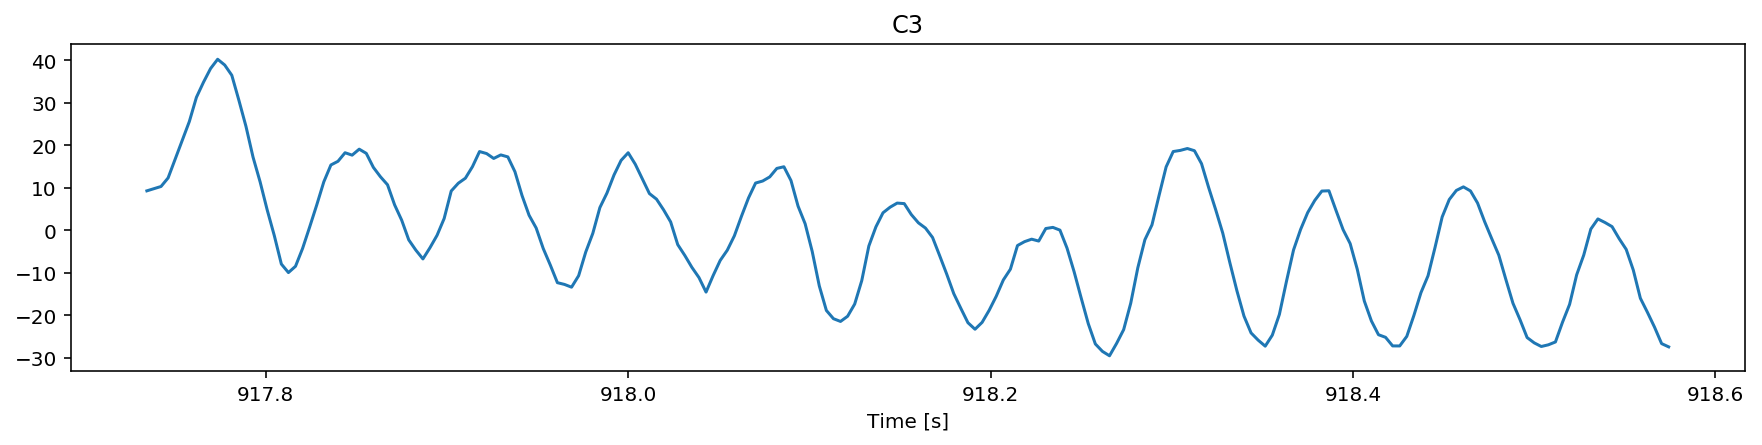

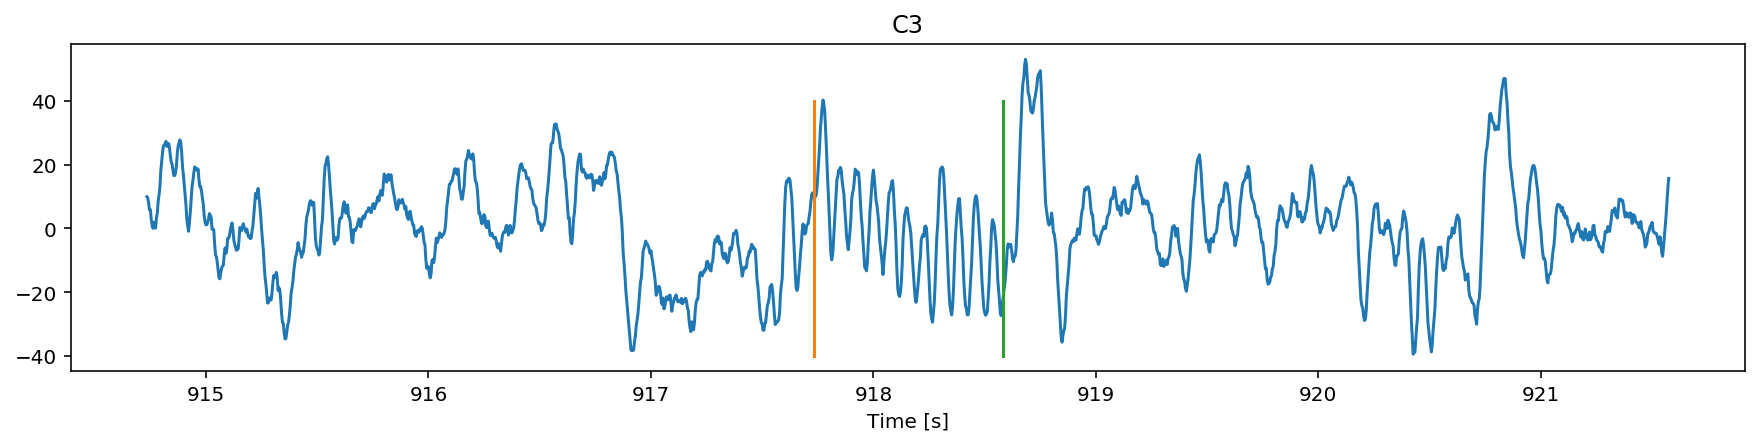

In [101]:
print(type(annotations)) #<class 'tuple'>
print(len(annotations))  # 3
# First is onset in seconds
# Second is duration in seconds
# third describe channel (C3-LER), type spindle, expert E1.

n = 2
print("annotation: onset is %f    \nduration is %s    \ndescription is %s" % (annotations[0][n],annotations[1][n],annotations[2][n]))

# Let's see a spindle
onset = annotations[0][n]
offset = onset + annotations[1][n]

onset_idx = int(onset*fs)
offset_idx = int(offset*fs)

plt.figure(figsize=(15, 3))
plt.plot(time_axis[onset_idx:offset_idx], signal_C3[onset_idx:offset_idx])
plt.title('C3')
plt.xlabel('Time [s]')
plt.show()

# Let add some temporal context
onset_idx = int((onset-3)*fs)
offset_idx = int((offset+3)*fs)

plt.figure(figsize=(15, 3))
plt.plot(time_axis[onset_idx:offset_idx], signal_C3[onset_idx:offset_idx])
plt.plot([onset, onset],[-40,40])
plt.plot([offset, offset],[-40,40])
plt.title('C3')
plt.xlabel('Time [s]')
plt.show()

In [ ]:
# TODO:

# Make a table in which we compute
# reg id: n_epochs, n2_epochs, n_marks_E1, n_marks_E2

# Transform the files to the following arrays (and I can save them and share them to Rosario):
# say that is the channel C3-CLE, 256Hz.
# marks of both experts in the format start_sample end_sample
# stages as a single vector in the format (for the absent stages just fill with ?)
#      {'1', 2', '3', '4', 'R', 'W', '?'}  ->  1,2,3,4, 5,6, 7
# save both as .txt files.